In [2]:
import torch.nn  as nn
import importlib
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
import torchvision.utils
import matplotlib.pyplot as plt
import random
import tarfile
import os
from torchvision.transforms import transforms
from torch.utils.data import random_split
from torch.utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
import torch
import MachineLearningUtils as mlu
importlib.reload(mlu)

<module 'MachineLearningUtils' from 'S:\\Machine Learning\\Basics\\MachineLearningUtils.py'>

In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"

In [4]:
dataset = CIFAR10(root = "data/cifar10/" , download = True , transform= transforms.ToTensor())

Files already downloaded and verified


In [5]:
download_url(dataset_url,'.')

Using downloaded and verified file: .\cifar10.tgz


In [6]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [7]:
data_dir = './data/cifar10'
os.listdir(data_dir)
train_folder = data_dir  + '/train'
classes = os.listdir(train_folder)
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
airplane_files = os.listdir(train_folder + '/airplane')
print('Num files of airplanes are ' +str(len(airplane_files)))


Num files of airplanes are 5000


In [9]:
print(airplane_files[:5])

['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [10]:
dataset = ImageFolder(data_dir + '/train', transform = ToTensor())
classes = dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
print(dataset)
print(len(dataset))

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()
50000


Label is dog


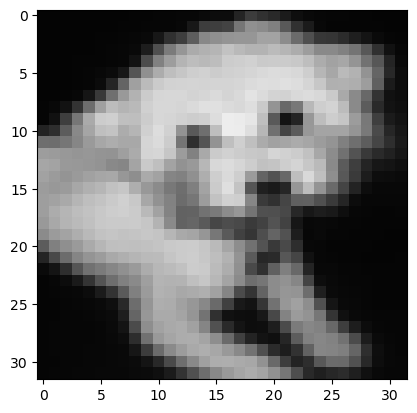

In [12]:
mlu.show_image(classes,*dataset[random.randint(0,len(dataset))])

In [13]:
random_seed = 42
torch.manual_seed(random_seed)
validation_set_len = 5000
total_dataset_len = len(dataset)
train_dataset_len = total_dataset_len - validation_set_len
print(train_dataset_len)

45000


In [14]:
train_dataset , validation_dataset = random_split(dataset , [train_dataset_len,validation_set_len])

In [15]:
print(train_dataset, validation_dataset)

<torch.utils.data.dataset.Subset object at 0x0000020410186630> <torch.utils.data.dataset.Subset object at 0x0000020410185850>


In [16]:
batch_size = 128

In [17]:
train_dataloader = DataLoader(dataset= train_dataset, batch_size = batch_size , shuffle= True , num_workers=4)
validation_dataloader = DataLoader(dataset= validation_dataset , batch_size = batch_size * 2 , shuffle= False , num_workers= 4)

train_dataloader = mlu.DeviceDataLoader(train_dataloader, device= mlu.get_default_device())
validation_dataloader  = mlu.DeviceDataLoader(validation_dataloader, device= mlu.get_default_device())

<h4> Validation Batch size is twice because it does not calculate the gradient which means it will have less memory</h4>

torch.Size([3, 274, 546])
torch.Size([274, 546, 3])


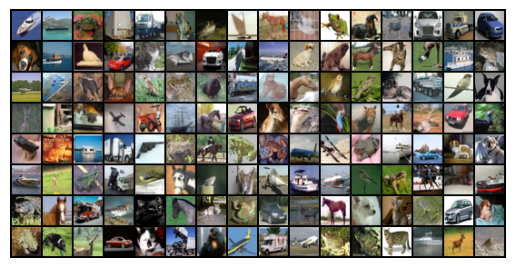

In [18]:
mlu.show_batch(train_dataloader)

torch.Size([3, 546, 546])
torch.Size([546, 546, 3])


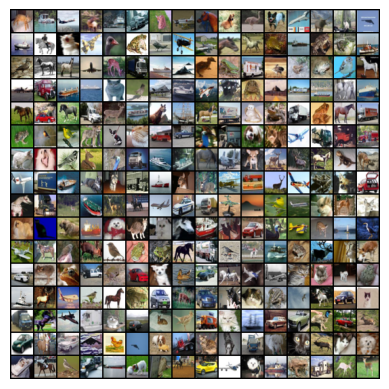

In [19]:
mlu.show_batch(validation_dataloader)

In [20]:
for images , labels in train_dataloader :
    inputs = images.reshape(-1,32*32*3)
    print(inputs.shape) #[-1,3072]
    break
input_size = inputs.shape[-1]  #3072
hidden_size = 32
     

torch.Size([128, 3072])


In [21]:
conv2d = nn.Conv2d(in_channels= 3 , out_channels= 8 ,kernel_size= 3 ,stride= 1 , padding=1)
conv2d = mlu.to_default_device(conv2d)

In [22]:
for images , labels in train_dataloader :
    print(images.shape)
    print(conv2d(images).shape)

    print(images[0].shape)
    print(conv2d(images[0]).shape)    
    break
    

torch.Size([128, 3, 32, 32])
torch.Size([128, 8, 32, 32])
torch.Size([3, 32, 32])
torch.Size([8, 32, 32])


In [23]:
max_pool = nn.MaxPool2d(2,2)

Max pool will reduce the size by the parameter passed , it will just take a max of the data inside the grid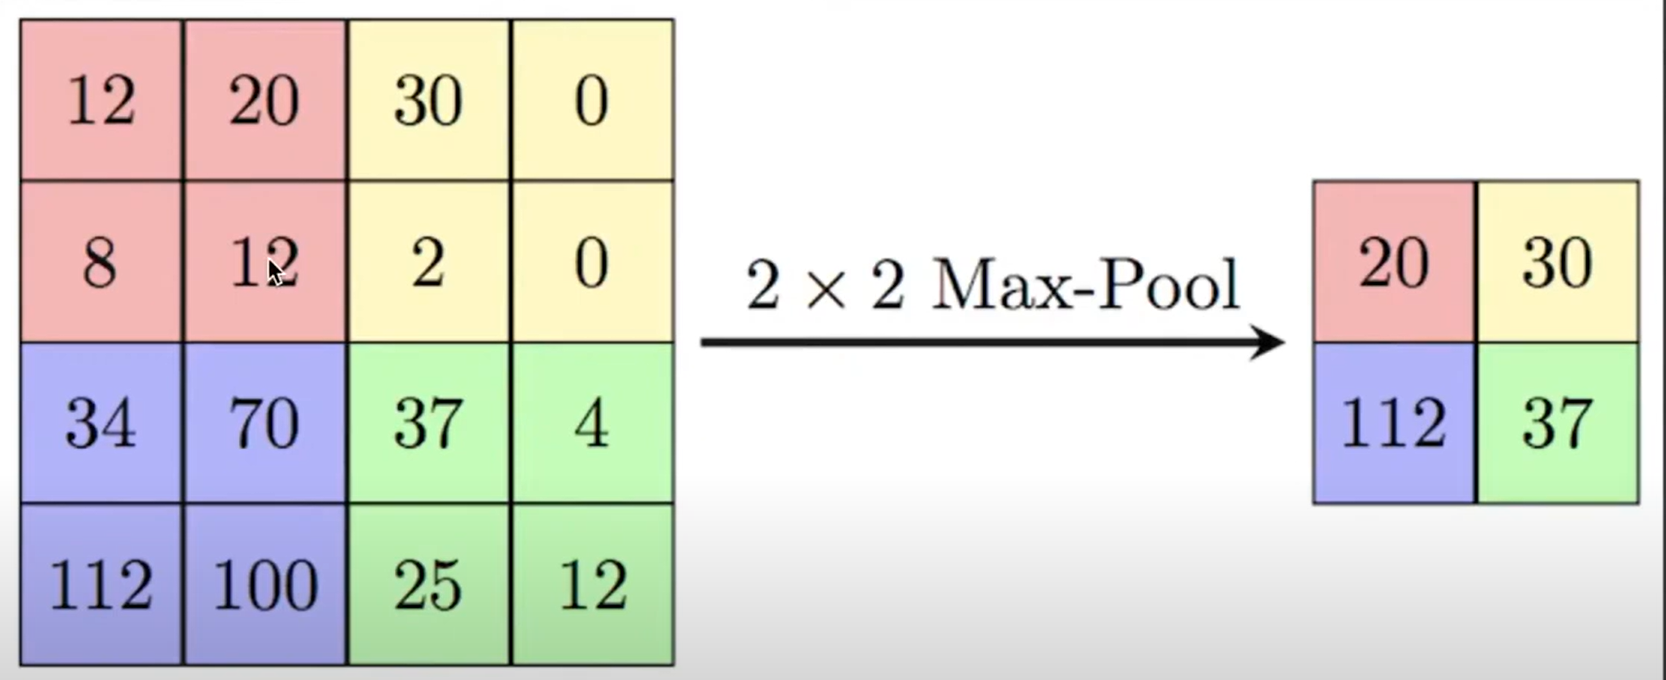

In [24]:
for images , labels in train_dataloader :
    conv2do = conv2d(images)
    print(conv2do.shape)
    max_poolo = max_pool(conv2do)
    print(max_poolo.shape)
    break

torch.Size([128, 8, 32, 32])
torch.Size([128, 8, 16, 16])


In [26]:
class ClassficationConvModel(nn.Module):
    def __init__(self , input_size , out_size):
        super().__init__()
        self.sequential = nn.Sequential(
            # 3x32x32
            nn.Conv2d( 3 , 32 ,kernel_size= 3 ,stride= 1 , padding=1),
            # 32x32x32
            nn.ReLU(),
            # 32x32x32
            nn.Conv2d( 32 , 64 ,kernel_size= 3 ,stride= 1 , padding=1),
            # 64x32x32
            nn.MaxPool2d(2,2), #output is 
            # 64x16x16

            nn.Conv2d( 64 , 128 ,kernel_size= 3 ,stride= 1 , padding=1),
            # 128x16x16
            nn.ReLU(),
            # 128x16x16
            nn.Conv2d( 128 , 128 ,kernel_size= 3 ,stride= 1 , padding=1),
            # 128x16x16
            nn.ReLU(),
            # 128x16x16
            nn.MaxPool2d(2,2), #output is 
            # 128x8x8


            nn.Conv2d( 128 , 256 ,kernel_size= 3 ,stride= 1 , padding=1),
            # 256x8x8
            nn.ReLU(),
            # 256x8x8
            nn.Conv2d( 256 , 256 ,kernel_size= 3 ,stride= 1 , padding=1),
            # 256x8x8
            nn.ReLU(),
            # 256x8x8
             nn.MaxPool2d(2,2), #output is 
            # 256x4x4
            
            nn.Flatten(),
            # 256*4*4 x 1
            nn.Linear(256*4*4,1024),
            #1024
            nn.ReLU(),
            #1024
            nn.Linear(1024,512),
            #512
            nn.ReLU(),
            #512
            nn.Linear(512,10)
            #10
        )

    def forward(self , xb):
        return self.sequential(xb)

    def training_step(self,batch):
        images,labels = batch
        output = self(images)
        loss = F.cross_entropy(output,labels)
        return loss

    def validation_step(self,batch):
        images,labels = batch
        output = self(images)
        loss = F.cross_entropy(output,labels)
        acc = self.accuracy(output , labels)
        return loss,acc
         

    def epoch_end(self , epoch , result):
        print('Epoch ' + str(epoch) +  ' Validation Loss : ' + str(result['epoch_val_loss']) + ' Validation Accuracy' + str(result['epoch_val_accuracy']) + "\n")

    def accuracy(self,outputs , label):
        probabilities,prediction = torch.max(outputs,dim=1)
        return torch.sum(label == prediction) / label.numel()   



In [27]:
model = ClassficationConvModel(input_size = 32*32 * 3,out_size=len(classes))
model = mlu.to_default_device(model)

In [28]:
for param in model.parameters() :
    print(param.shape) 

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([1024, 4096])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [29]:
for batch in train_dataloader : 
    loss = model.training_step(batch)
    print('Loss' , loss.item())
    break
    

Loss 2.303771495819092


In [68]:
def fit(epochs , lr , model , train_loader , val_loader , opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    result = mlu.TrainingResult()
    for epoch in range(epochs):
        torch.enable_grad()
        model.train()
        for batch in train_loader:
            loss = model.training_step(batch)
            result.add_train_result(mlu.TrainStepResult(loss))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            

        torch.no_grad()
        model.eval()
        for val_batch in val_loader:
            loss,acc = model.validation_step(val_batch)
            result.add_validation_result(mlu.ValidationStepResult(loss,acc))

        result.val_epoch_end()
        result.log_last_epoc_result()
        
    return result

In [30]:
model.load_state_dict(torch.load("mnist-multilayer_cnn_cifar10.pth"))

<All keys matched successfully>

In [83]:
history = fit(10, 0.001,model,train_loader=train_dataloader,val_loader= validation_dataloader , opt_func = torch.optim.Adam)
torch.save(model.state_dict(),"mnist-multilayer_cnn_cifar10.pth")

tensor(0.7734, device='cuda:0')
tensor(0.8086, device='cuda:0')
tensor(0.7539, device='cuda:0')
tensor(0.7305, device='cuda:0')
tensor(0.7969, device='cuda:0')
tensor(0.7500, device='cuda:0')
tensor(0.7930, device='cuda:0')
tensor(0.7383, device='cuda:0')
tensor(0.8008, device='cuda:0')
tensor(0.7852, device='cuda:0')
tensor(0.7969, device='cuda:0')
tensor(0.8359, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8164, device='cuda:0')
tensor(0.7539, device='cuda:0')
tensor(0.7656, device='cuda:0')
tensor(0.7383, device='cuda:0')
tensor(0.7617, device='cuda:0')
tensor(0.7656, device='cuda:0')
tensor(0.7794, device='cuda:0')
Epoch 1 Validation Loss : 1.0834308862686157 Validation Accuracy0.7778377532958984

tensor(0.7734, device='cuda:0')
tensor(0.8203, device='cuda:0')
tensor(0.7695, device='cuda:0')
tensor(0.7227, device='cuda:0')
tensor(0.8047, device='cuda:0')
tensor(0.7422, device='cuda:0')
tensor(0.7617, device='cuda:0')
tensor(0.7305, device='cuda:0')
tensor(0.7695, devic

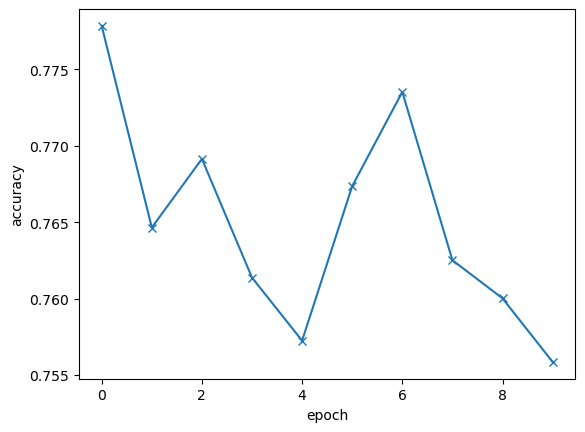

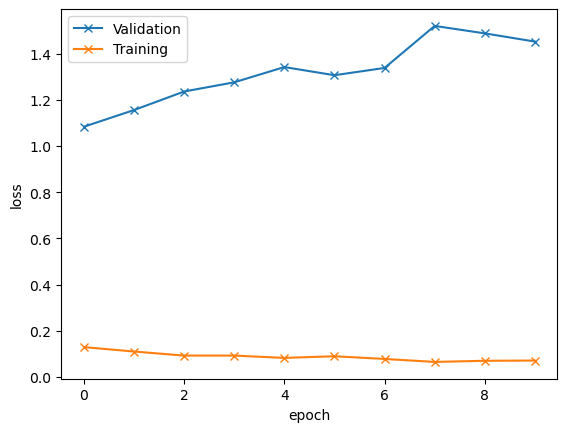

In [84]:
mlu.draw_training_result(history)

In [31]:
test_dataset = ImageFolder(data_dir + '/test', transform = ToTensor())

In [89]:
def predict_image(img , model):
    torch.no_grad()
    img = mlu.to_default_device(img)
    image_with_batch_dimention = img.unsqueeze(0) #adds another dimention as the model as the batch size as the first dimention.
    result = model(image_with_batch_dimention)
    max_value , index = torch.max(result,dim = 1)
    print(result)
    
    
    return max_value.item(),index.item()
    

tensor([[-10.1299,  -6.8147,  -2.0494,  11.5019,  -9.1427,   0.2270, -12.1195,
          -0.4432,  -8.2507,  -9.2196]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Label is cat Prediction is cat


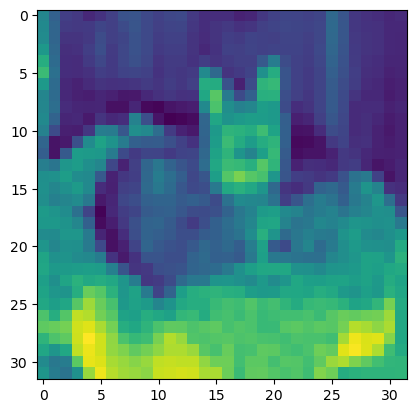

In [91]:
img,label=test_dataset[random.randint(0,len(test_dataset))]
max_value, index= predict_image(img,model)

print("Label is " + classes[label] + " Prediction is " + classes[index])

plt.imshow(img[0])